<a href="https://colab.research.google.com/github/mekhi-woods/HiloCATsSN1991bg/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
START UP
"""
import os
import shutil
if os.path.exists('/content/HiloCATsSN1991bg') == True:
    shutil.rmtree('/content/HiloCATsSN1991bg')
    !git clone https://github.com/mekhi-woods/HiloCATsSN1991bg.git
else:
    !git clone https://github.com/mekhi-woods/HiloCATsSN1991bg.git

!pip install --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple snpy
!pip install requests
!pip install ztffp


In [ ]:
"""
Plotting 91bg like 1a to get an idea of what they look like
"""
import matplotlib.pyplot as plt
import numpy as np

FILTER_WHEEL = ['u', 'g', 'r', 'i', 'B', 'V0']

if __name__ == '__main__':
    KrisciunasPath = "/content/HiloCATsSN1991bg/targetLists/91bglike_justnames.txt"
    KrisciunasNames = np.genfromtxt(KrisciunasPath, dtype=str, delimiter=', ')

    allCPSPhot = "/content/HiloCATsSN1991bg/data/CSPdata/SN_photo.dat"
    allCPSPhotData = np.genfromtxt(allCPSPhot, dtype='str')

    names = allCPSPhotData[:,0]
    filters = allCPSPhotData[:,1]
    time = allCPSPhotData[:,2]
    light = allCPSPhotData[:,3]
    err = allCPSPhotData[:,4]

    plt.figure(figsize=(10,6))
    sigma = 1
    for tar in KrisciunasNames:
        for n in range(len(FILTER_WHEEL)):
            # output_names = names[(names == tar) & (filters == FILTER_WHEEL[n])]
            output_light = light[(names == tar) & (filters == FILTER_WHEEL[n])].astype('float64')
            output_time = time[(names == tar) & (filters == FILTER_WHEEL[n])].astype('float64') + 53000
            output_err = err[(names == tar) & (filters == FILTER_WHEEL[n])].astype('float64')
            plt.errorbar(output_time, output_light, yerr=output_err*sigma, fmt='o', label=FILTER_WHEEL[n])

        plt.title(tar); plt.xlabel('Time [MJD]'); plt.ylabel('Intensity [mag]')
        plt.gca().invert_yaxis()
        plt.legend()
        # plt.savefig('save\\'+str(tar)+'.png')
        plt.show()
        break


In [ ]:
"""
SNooPy fitting on CSP data
"""
import matplotlib.pyplot as plt
import numpy as np
import glob
import snpy
import os
from zipfile import ZipFile

USE_SAVED = False

def recover_dir():
    if os.path.exists('/content/saved_models') == False:
        os.mkdir('/content/saved_models')
    if os.path.exists('/content/snpy_fit_plots') == False:
        os.mkdir('/content/snpy_fit_plots')
    if os.path.exists('/content/snpy_fit_plots/snpyplots.zip'):
        os.remove('/content/snpy_fit_plots/snpyplots.zip')
    return

def snpy_fit(filePath, model='max_model', shapeParam='dm15', BandsToFit = ['B','g','r','i'], summarize=True, saveplots=False, saveLoc='/content/snpy_fit_plots/'):
    s = snpy.get_sn(filePath)

    # Set model parameters
    s.choose_model(model, stype=shapeParam)
    s.set_restbands() # Auto pick appropriate rest-bands

    # Fit data -- using David configurations
    fitargs = {'mangle':1,'calibration':0, 'quiet':False} # I don't remember what calibration is
    s.fit(BandsToFit,
          dokcorr=True,
          k_stretch=False,
          reset_kcorrs=True,
          **fitargs)

    # Show results
    if summarize:
        s.summary()
        # for param in s.parameters:
        #     print("{} = {} +/- {}".format(param, s.parameters[param], s.errors[param]))
    if saveplots:
        print('Plot saved @', saveLoc+filePath[-17:-9]+'_snpyplots')
        s.plot(outfile=saveLoc+filePath[-17:-9]+'_snpyplots')
        plt.show()

        with ZipFile('/content/snpy_fit_plots/snpyplots.zip', 'a') as zip_object:
            zip_object.write(saveLoc+filePath[-17:-9]+'_snpyplots.png')

    return s

def SNooPy2_fitting(CPSpath, tarNames, model='EBV_model2', shape='st', bands=['B','g','r','i'], output=False, snpyPlots=False):
    problemChildren = []

    if len(bands) == 0:
        bands = None

    tarPaths = []
    for tar in tarNames:
        tarPaths.append(CPSpath+'/SN'+str(tar)+'_snpy.txt')

    SNeDistances = {}
    SNeRedshifts = {}
    SNeParams = {}

    for i in range(len(tarPaths)):
        tarName = 'SN'+tarNames[i]
        tarSave = '/content/saved_models/'+tarName+'_'+model+'.snpy'
        print('[ '+str(i+1)+' / '+str(len(tarPaths))+'] Fiting data for '+tarName+'...')

        # Create/Retrieve Fit
        valid = True

        if os.path.exists(tarSave) and USE_SAVED:
            print(tarName, 'found in files! Pulling data...')
            s_n = snpy.get_sn(tarSave)
        elif os.path.exists(tarPaths[i]):
            try:
                s_n = snpy_fit(tarPaths[i],
                                model=model,
                                shapeParam=shape,
                                BandsToFit=None,
                                summarize=output,
                                saveplots=snpyPlots,
                                saveLoc='/content/snpy_fit_plots/') # Enter snpy fit function
            except ValueError:
                problemChildren.append(tarName)
                print('[!!!] ValueError: No data near maximum light... skipping\n')
                valid = False
            except RuntimeError:
                problemChildren.append(tarName)
                print('[!!!] RuntimeError: Model has trailed off fitting filter... skipping\n')
                valid = False
            except TypeError:
                problemChildren.append(tarName)
                print('[!!!] TypeError: m > k must hold (I have no clue what this means)... skipping\n')
                valid = False
            except:
                problemChildren.append(tarName)
                print('[!!!] Unknown Error... skipping\n')
                valid = False
        else:
            print(tarName, 'does not exsist in CSP data... skipping')
            valid = False

        if valid:
            # Save model
            s_n.save(tarSave)

            # Pull SNooPY distance
            snpy_mu = s_n.get_distmod() # Nab paramaters from SNe objects)

            # Update dictionary/list
            SNeDistances.update({tarName: snpy_mu})
            SNeRedshifts.update({tarName: s_n.z})
            SNeParams.update({tarName: [s_n.st, s_n.Tmax, s_n.EBVhost]})

            # Print info
            print('Redshift:\t z = '+str(s_n.z))
            print('Distance: \t mu = '+str(round(snpy_mu, 4))+'\n')

    print('Problem children:\n', '[', len(problemChildren), ']', problemChildren)
    plt.clf()
    return SNeDistances, SNeRedshifts, SNeParams

def plot_DvD(snpyDistances, burnsDistances, size=(8,5), save=False):
    print("Ploting differences in distance calculations...")
    plt.figure(figsize=size)
    for x in snpyDistances:
        try:
            plt.scatter(burnsDistances[x], snpyDistances[x], marker='o')
            plt.text(burnsDistances[x]+0.05, snpyDistances[x]-0.05, x, fontsize='xx-small')
            print('Burns Distance:', burnsDistances[x], '| SNooPy Distance:', snpyDistances[x])
        except KeyError:
            print(x, 'not found.')
            pass
    plt.title("Burns v. SNooPy Distance")
    plt.xlabel('Burns Distance'); plt.ylabel('SNooPy Distance')
    plt.xlim(min(burnsDistances.values()), max(burnsDistances.values()))
    plt.ylim(min(burnsDistances.values()), max(burnsDistances.values()))

    if save:
        plt.savefig('burns_v_snpy_dist.png')

    plt.show()
    return

def plot_residuals(snpyDistances, burnsDistances, snpyRedshifts, size=(8,5), save=False):
    print("Ploting residuals...")
    plt.figure(figsize=size)
    for x in snpyDistances:
        try:
            plt.scatter(snpyRedshifts[x], abs(burnsDistances[x]-snpyDistances[x]), marker='o')
            plt.text(snpyRedshifts[x], abs(burnsDistances[x]-snpyDistances[x]), x, fontsize='xx-small')
            print('Redshift:', snpyRedshifts[x], '| Burns-SNooPy Distance:', burnsDistances[x]-snpyDistances[x])
        except KeyError:
            print(x, 'not found.')
            pass
    plt.title("Burns-SNooPy Residuals"); plt.xlabel('Redshift'); plt.ylabel('Burns-SNooPy')
    if save:
        plt.savefig('burns-snpy_res.png')
    plt.show()
    return

if __name__ == '__main__':
    recover_dir()

    # Initialize Data
    KrisciunasNames = np.genfromtxt("/content/HiloCATsSN1991bg/targetLists/91bglike_justnames.txt", dtype=str, delimiter=', ')

    burnsData = np.genfromtxt('/content/HiloCATsSN1991bg/targetLists/burns+25table2ext.txt', dtype=str)
    burnsDistances = {}
    burnsNames = burnsData[:, 0]
    for tar in np.stack((burnsData[:, 0], burnsData[:, 14]), axis=1):
        burnsDistances.update({'SN'+tar[0]: float(tar[1])})

    # Fitting Data
    # snpyDistances, snpyRedshifts = SNooPy2_fitting(CPSpath='/content/HiloCATsSN1991bg/data/CSPdata',
    #                                                tarNames=KrisciunasNames,
    #                                                model='EBV_model2',
    #                                                shape='st',
    #                                                bands=['B','g','r','i'],
    #                                                output=False,
    #                                                snpyPlots=True)

    ATLASnames = glob.glob('/content/ATLASsnpy/*')
    for n in range(len(ATLASnames)):
        ATLASnames[n] = ATLASnames[n][21:-9]
    snpyDistances, snpyRedshifts, snpyParams = SNooPy2_fitting(CPSpath='/content/ATLASsnpy',
                                                tarNames=ATLASnames,
                                                model='EBV_model2',
                                                shape='st',
                                                bands=['ATgr', 'ATri'],
                                                output=True,
                                                snpyPlots=True)
    with open('/content/snpy_fit_plots/snpy_fit_params.txt', 'w') as f:
        f.write('Object Name, mu, z, st, Tmax, EBVhost\n')
        for name in snpyDistances:
            f.write(str(name)+', '+str(snpyDistances[name])+', '+str(snpyRedshifts[name])
                    +', '+str(snpyParams[name][0])+', '+str(snpyParams[name][1])+', '+str(snpyParams[name][2])+'\n')

    # # Plot Distance v. Distance
    # plot_DvD(snpyDistances, burnsDistances, size=(8,5), save=True)

    # # Plot Residuals
    # plot_residuals(snpyDistances, burnsDistances, snpyRedshifts, size=(8,5), save=True)


In [ ]:
"""
DR3's Tmax vs. st vs EBVhost
"""
import matplotlib.pyplot as plt
import numpy as np

if __name__ == "__main__":
    data = np.genfromtxt('/content/HiloCATsSN1991bg/DR3_fits.dat', dtype=str, skip_header=1)
    DR3_st = np.stack((data[:, 1].astype(float), data[:, 2].astype(float)), axis=1)
    DR3_Tmax = np.stack((data[:, 5].astype(float), data[:, 6].astype(float)), axis=1)
    DR3_EBVhost = np.stack((data[:, 25].astype(float), data[:, 26].astype(float)), axis=1)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
    fig.suptitle("DR3's Tmax vs. st vs EBVhost")
    sigmas = [[1, 1], [1, 1], [1, 1]]

    # Tmax vs. st
    ax1.errorbar(DR3_Tmax[:, 0], DR3_st[:, 0],
                 xerr=DR3_Tmax[:, 1]*sigmas[0][0], yerr=DR3_st[:, 1]*sigmas[0][1],
                 fmt='yo')
    ax1.set_xlabel('Tmax'); ax1.set_ylabel('st')
    ax1.set_title('Tmax vs. st, sigma(x='+str(sigmas[0][0])+', y='+str(sigmas[0][1])+')')

    # st vs. EBVhost
    ax2.errorbar(DR3_st[:, 0], DR3_EBVhost[:, 0],
                 xerr=DR3_st[:, 1]*sigmas[1][0], yerr=DR3_EBVhost[:, 1]*sigmas[1][1],
                 fmt='bo')
    ax2.set_xlabel('st'); ax2.set_ylabel('EBVhost')
    ax2.set_title('st vs. EBVhost, sigma(x='+str(sigmas[1][0])+', y='+str(sigmas[1][1])+')')

    # Tmax vs. EBVhost
    ax3.errorbar(DR3_Tmax[:, 0], DR3_EBVhost[:, 0],
                 xerr=DR3_Tmax[:, 1]*sigmas[2][0], yerr=DR3_EBVhost[:, 1]*sigmas[2][1],
                 fmt='ro')
    ax3.set_xlabel('Tmax'); ax3.set_ylabel('EBVhost')
    ax3.set_title('Tmax vs. EBVhost, sigma(x='+str(sigmas[2][0])+', y='+str(sigmas[2][1])+')')

    plt.show()


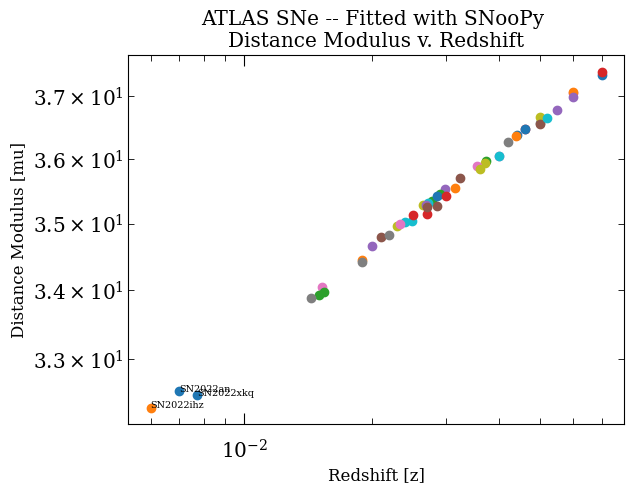

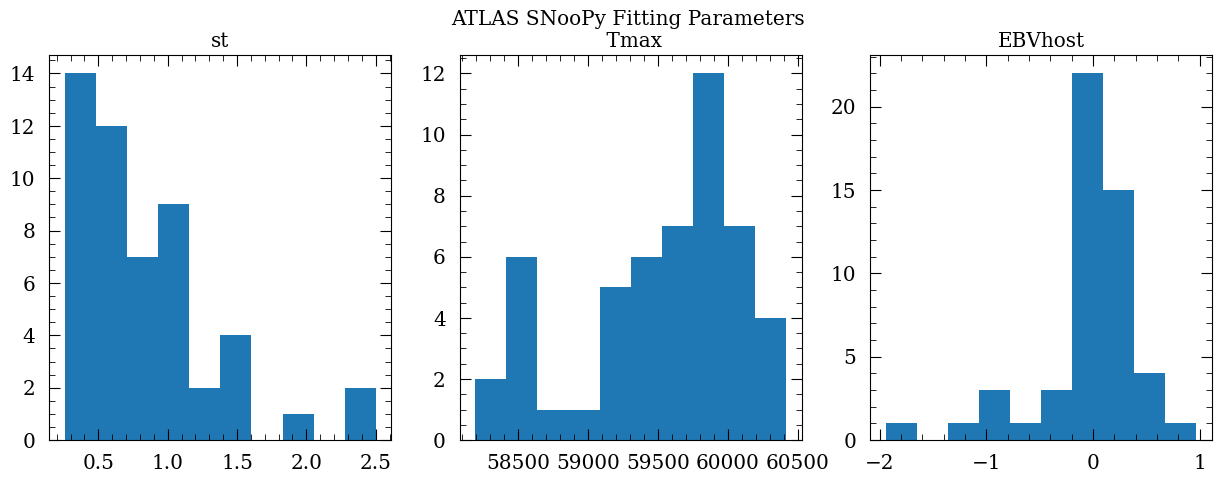

In [99]:
"""
ATLAS Data
"""
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
import requests
import os
import glob
import time
from requests.auth import HTTPBasicAuth
from zipfile import ZipFile
from HiloCATsSN1991bg.scripts import tns_redshifts

API_TOKEN = "7f4e1dee8f52cf0c8cdaf55bf29d04bef4810fb4"
ATLAS_PATH = '/content/ATLAS'
N_ITER = 0 # 0 turns iteration limit off
PLOT_MODE = 'SOLO' # SOLO or COMBINED
USE_PAST_CALC = True # Uses past calculations to speed up code

tns_bot_id = '73181'
tns_bot_name = 'YSE_Bot1'
tns_bot_api_key = '0d771345fa6b876a5bb99cd5042ab8b5ae91fc67'


class ATLAS_SN():
    def __init__(self, ATLASname='EmptySN', objname='SN####abc', RA=0.00000000000, DEC=0.00000000000, z=0.00000000000,
                 t_o=np.array([0]), flux_o=np.array([0]), dflux_o=np.array([0]), mag_o=np.array([0]), dmag_o=np.array([0]),
                 t_c=np.array([0]), flux_c=np.array([0]), dflux_c=np.array([0]), mag_c=np.array([0]), dmag_c=np.array([0])):
        self.ATLASname=ATLASname
        self.objname=objname
        self.RA=RA
        self.DEC=DEC
        self.z=z

        self.t_o=t_o
        self.flux_o=flux_o
        self.dflux_o=dflux_o
        self.mag_o=mag_o
        self.dmag_o=dmag_o

        self.t_c=t_c
        self.flux_c=flux_c
        self.dflux_c=dflux_c
        self.mag_c=mag_c
        self.dmag_c=dmag_c
        return

    def __str__(self):
        return ('SN: '+self.ATLASname+' @ ('+str(self.RA)+', '+str(self.DEC)+')\n'+
                'O-Filter:'+
                '\t t [MJD]: '+str(np.min(self.t_o))+'...'+str(np.max(self.t_o))+'\n'+
                '\t\t flux [uJy]: '+str(np.min(self.flux_o))+'...'+str(np.max(self.flux_o))+'\n'+
                '\t\t dflux [duJy]: '+str(np.min(self.dflux_o))+'...'+str(np.max(self.dflux_o))+'\n'+
                '\t\t mag: '+str(np.min(self.mag_o))+'...'+str(np.max(self.mag_o))+'\n'+
                '\t\t dmag: '+str(np.min(self.dmag_o))+'...'+str(np.max(self.dmag_o))+'\n'+
                'C-Filter:'+
                '\t t [MJD]: '+str(np.min(self.t_c))+'...'+str(np.max(self.t_c))+'\n'+
                '\t\t flux [uJy]: '+str(np.min(self.flux_c))+'...'+str(np.max(self.flux_c))+'\n'+
                '\t\t dflux [duJy]: '+str(np.min(self.dflux_c))+'...'+str(np.max(self.dflux_c))+'\n'
                '\t\t mag: '+str(np.min(self.mag_c))+'...'+str(np.max(self.mag_c))+'\n'+
                '\t\t dmag: '+str(np.min(self.dmag_c))+'...'+str(np.max(self.dmag_c))+'\n')

    def coords(self):
        return('('+str(self.RA)+', '+str(self.DEC)+')')

    def flux_to_mag(self):
        return [[-2.5*np.log10(self.flux_o) + 23.9, 1.0857*self.dflux_o/self.flux_o],
                [-2.5*np.log10(self.flux_c) + 23.9, 1.0857*self.dflux_c/self.flux_c]]

def recover_dir():
    if os.path.exists(ATLAS_PATH) == False:
        os.mkdir(ATLAS_PATH)
    if os.path.exists('/content/ATLASplots') == False:
        os.mkdir('/content/ATLASplots')
    if os.path.exists('/content/ATLASsnpy') == False:
        os.mkdir('/content/ATLASsnpy')
    return

def TNS_details(ra, dec):
    # Code from David

    headers = tns_redshifts.build_tns_header(tns_bot_id, tns_bot_name)
    tns_api_url = f"https://www.wis-tns.org/api/get"

    # get the API URLs
    search_tns_url = tns_redshifts.build_tns_url(tns_api_url, mode="search")
    get_tns_url = tns_redshifts.build_tns_url(tns_api_url, mode="get")

    search_data = tns_redshifts.build_tns_search_query_data(tns_bot_api_key, ra, dec)
    transients = tns_redshifts.rate_limit_query_tns(search_data, headers, search_tns_url)

    get_data = tns_redshifts.build_tns_get_query_data(tns_bot_api_key, transients[0])
    transient_detail = tns_redshifts.rate_limit_query_tns(get_data, headers, get_tns_url)

    return transient_detail

def data_collection():
        if os.path.exists('/content/tmp.npz'):
            pickle = np.load('tmp.npz', allow_pickle=True)
            data = pickle['data']

        data = requests.post(
            'https://star.pst.qub.ac.uk/sne/atlas4/api/objectlist/',
            headers={'Authorization': f'Token {API_TOKEN}'},
            data={'objectlistid':2}
        ).json()

        np.savez('tmp.npz', data=data)

        count = 0
        for d in data:
            if d['observation_status'] is not None and d['observation_status'].startswith('SN Ia') and '91bg' in d['observation_status']:
                print(d['atlas_designation'],d['observation_status'].replace(' ',''),d['ra'],d['dec'])
                count += 1

                ids = d['id']
                base_url = 'https://star.pst.qub.ac.uk/sne/atlas4/lightcurveforced/1161048951013729300/'
                new_url = base_url.replace('1161048951013729300/',str(ids))
                print(new_url)

                idfile = ATLAS_PATH+'/' + str(ids)+'.txt'
                if os.path.exists(idfile):
                    continue
                urllib.request.urlretrieve(str(new_url), str(idfile))
                print(idfile)

            if count > 300:
                break

def main_processing(err_max=100, yaxis='flux', plot=True, quiet=False):
    # [2.1] Aquire Data
    if quiet == False:
        print('Retrieving data from...', ATLAS_PATH)
    files = glob.glob(ATLAS_PATH+'/*')
    problemChildren = ['1032212120425304400']   # Running list of problematic SNe
                                                # '1032212120425304400' - David believes it might be a shock breakout but ATLAS reports it as SN1a
                                                #
    # [2.2] Validate Data
    if quiet == False:
        print('Sorting data...')
    SNe = []
    for n in range(len(files)):
        if quiet == False:
            print('[', n+1, '/', len(files), '] Validating data for...', files[n][15:-4])
        result = slice_data(path=files[n], err_max=err_max, output=False)
        if result != None:
            SNe.append(result)
        else:
            problemChildren.append(files[n][15:-4])
        if N_ITER != 0 and n+1 >= N_ITER:
            break

    # [2.3] Remove problem children
    print('Problem Children: ', problemChildren)
    for SN in SNe:
        for probname in problemChildren:
            if SN.ATLASname == probname:
                print('Removing...', SN.ATLASname)

    # [2.4] Save RA, DEC, Redshift, and Object Name
    t_lim = 5
    print(t_lim, 'second pause between entries...')
    with open('ATLASVariables.txt', 'w') as f:
        f.write('objname, ATLASname, RA, DEC, z\n')
        for n in range(len(SNe)):
            obj = TNS_details(ra=SNe[n].RA, dec=SNe[n].DEC)
            SNe[n].z = obj['redshift']
            SNe[n].objname = 'SN'+obj['objname']

            print('[ '+str(n+1)+' / '+str(len(SNe))+' ]', SNe[n].ATLASname+':', SNe[n].objname, '| z =', SNe[n].z)
            f.write(str(SNe[n].objname)+', '+str(SNe[n].ATLASname)+', '+str(SNe[n].RA)+', '+str(SNe[n].DEC)+', '+str(SNe[n].z)+'\n')

            time.sleep(t_lim)
            # break

    # [2.5] Plot data
    if plot and PLOT_MODE == 'SOLO':
        if quiet == False:
            print("Plotting data [indivisual]...")
        with ZipFile('/content/ATLASplots/ATLASplots.zip', 'w') as zip_object:
            for SN in SNe:
                solo_plotting(name=SN.ATLASname, coords=[SN.RA, SN.DEC], err_max=err_max,
                              t_o=SN.t_o, flux_o=SN.flux_o, flux_err_o=SN.dflux_o,
                              t_c=SN.t_c, flux_c=SN.flux_c, flux_err_c=SN.dflux_c,
                              save=True, saveLoc='/content/ATLASplots/')
                zip_object.write('/content/ATLASplots/'+SN.ATLASname+'_ATLASplot.png')
    elif plot and PLOT_MODE == 'COMBINED':
        if quiet == False:
            print("Plotting data [combined]...")

        fig, axs = plt.subplots(len(SNe), figsize=(12, len(SNe)*3.2))
        fig.tight_layout(pad=5.0)
        for n in range(len(SNe)):
            combined_plotting(ax=axs[n], name=SN.ATLASname, coords=[SN.RA, SN.DEC],
                              t_o=SNe[n].t_o, flux_o=SNe[n].flux_o, flux_err_o=SNe[n].dflux_o,
                              t_c=SN.t_c, flux_c=SN.flux_c, flux_err_c=SN.dflux_c)

    return SNe

def slice_data(path, err_max=100, output=True):
    name = path[15:-4]
    data = np.genfromtxt(path, dtype=str, delimiter=',')

    if len(data) == 0:
        print('[!!!] File '+name+' empty...skipping')
        return None

    filters = data[:, 6]
    t = data[:, 8].astype(float)
    flux = data[:, 24]
    dflux = data[:, 25]
    mag = np.char.replace(data[:, 3], '>', '') # Removes greater than symbols
    dmag = data[:, 4]

    # Finds the empty spots of flux and mag and records the element
    mod_empty = np.unique(np.hstack((np.hstack((np.where(flux == 'None')[0], np.where(dflux == 'None')[0])),
                                     np.hstack((np.where(mag == 'None')[0], np.where(dmag == 'None')[0])))))
    filters = np.delete(filters, mod_empty)
    t = np.delete(t, mod_empty).astype(float)
    flux = np.delete(flux, mod_empty).astype(float)
    dflux = np.delete(dflux, mod_empty).astype(float)
    mag = np.delete(mag, mod_empty).astype(float)
    dmag = np.delete(dmag, mod_empty).astype(float)

    # Finds negative fluxes
    mod_positive = np.unique(np.hstack((np.hstack((np.where(flux <= 0)[0], np.where(dflux <= 0)[0])),
                                np.hstack((np.where(mag <= 0)[0], np.where(dmag <= 0)[0])))))
    filters = np.delete(filters, mod_positive)
    t = np.delete(t, mod_positive)
    flux = np.delete(flux, mod_positive)
    dflux = np.delete(dflux, mod_positive)
    mag = np.delete(mag, mod_positive)
    dmag = np.delete(dmag, mod_positive)

    # Find outliers beyond error limit
    mod_err = np.unique(np.hstack(((np.where(abs(dflux) > err_max)[0]), np.where(abs(dmag) > err_max)[0]))) # Negatives fluxes & Error Limit
    filters = np.delete(filters, mod_err)
    t = np.delete(t, mod_err)
    flux = np.delete(flux, mod_err)
    dflux = np.delete(dflux, mod_err)
    mag = np.delete(mag, mod_err)
    dmag = np.delete(dmag, mod_err)

    tempSN = ATLAS_SN(ATLASname=name, RA=np.average(data[:, 1].astype(float)), DEC=np.average(data[:, 2].astype(float)),
                        t_o=t[np.where(filters=='o')[0]], flux_o=flux[np.where(filters=='o')[0]], dflux_o=dflux[np.where(filters=='o')[0]], mag_o=mag[np.where(filters=='o')[0]], dmag_o=dmag[np.where(filters=='o')[0]],
                        t_c=t[np.where(filters=='c')[0]], flux_c=flux[np.where(filters=='c')[0]], dflux_c=dflux[np.where(filters=='c')[0]], mag_c=mag[np.where(filters=='c')[0]], dmag_c=dmag[np.where(filters=='c')[0]])

    return tempSN

def solo_plotting(t_o, t_c, flux_o, flux_c, flux_err_o, flux_err_c, err_max, name='Empty', coords=[0, 0], size=(12, 4), save=False, saveLoc='/content/ATLASplots/'):
    plt.figure(figsize=size)

    plt.errorbar(t_o, flux_o, yerr=flux_err_o, fmt='o', color='orange')
    plt.errorbar(t_c, flux_c, yerr=flux_err_c, fmt='o', color='cyan')

    plt.title('Light Curve: '+str(name)+'\n'+str(coords[0])+', '+str(coords[1])+'\nMax Error = '+str(err_max))
    plt.xlabel('Time [MJD]')
    plt.ylabel('Flux [uJy]')
    plt.ylim(0)
    plt.savefig(saveLoc+name+'_ATLASplot.png')
    plt.show()
    return

def combined_plotting(ax, t_o, t_c, flux_o, flux_c, flux_err_o, flux_err_c, name='Empty', coords=[0, 0]):
    ax.errorbar(t_o, flux_o, yerr=flux_err_o, fmt='o', color='orange')
    ax.errorbar(t_c, flux_c, yerr=flux_err_c, fmt='o', color='cyan')

    ax.set_title('Light Curve: '+str(name)+'\n'+str(coords[0])+', '+str(coords[1]))
    ax.set_xlabel('Time [MJD]')
    ax.set_ylabel('Flux [uJy]')
    ax.set_ylim(0)
    return

def snpyASCIIFormat(SNe):
    knownVariables = {}
    skip_header = True
    with open('/content/ATLASVariables.txt', 'r') as f:
        for line in f.readlines():
            if skip_header:
                skip_header = False
                pass
            else:
                line = line[:-1].split(', ')
                name = line[1]
                line.remove(name)
                knownVariables.update({name : line})

    for SN in SNe:
        with open('/content/ATLASsnpy/'+str(SN.objname)+'_snpy.txt', 'w') as f:
            # Line 1
            # Ex. SN1981D 0.005871 50.65992 -37.23272
            #     Name    Helio Z  RA        Dec
            try:
                print('Found saved data for...', SN.ATLASname+'!')
                SN.objname = knownVariables[SN.ATLASname][0]
            except KeyError:
                print('No saved data for...', SN.ATLASname)
            f.write(str(SN.objname)+' '+str(SN.z)+' '+str(SN.RA)+' '+str(SN.DEC)+'\n')
            print(str(SN.objname)+' '+str(SN.z)+' '+str(SN.RA)+' '+str(SN.DEC)+'\n')

            # 'O'-filter photometry block
            # Ex. filter O
            #     674.8593      12.94   0.11
            #     Date (JD/MJD) mag     err
            f.write('filter ATri\n')
            for i in range(len(SN.t_o)):
                f.write(str(SN.t_o[i])+'\t'+str(SN.mag_o[i])+'\t'+str(SN.dmag_o[i])+'\n')

            # # 'C'-filter photometry block
            f.write('filter ATgr\n')
            for i in range(len(SN.t_c)):
                f.write(str(SN.t_c[i])+'\t'+str(SN.mag_c[i])+'\t'+str(SN.dmag_c[i])+'\n')

            # # Combined
            # f.write('filter r\n')
            # for i in range(len(SN.t_o)):
            #     f.write(str(SN.t_o[i])+'\t'+str(SN.mag_o[i])+'\t'+str(SN.dmag_o[i])+'\n')
            # for i in range(len(SN.t_c)):
            #     f.write(str(SN.t_c[i])+'\t'+str(SN.mag_c[i])+'\t'+str(SN.dmag_c[i])+'\n')

        # break

    return

def plot_SNooPy_mu_vs_z():
    data = np.genfromtxt('/content/snpy_fit_plots/snpy_fit_params.txt', delimiter=', ', dtype=str, skip_header=1)
    name, mu, z = data[:, 0], data[:, 1].astype(float), data[:, 2].astype(float)

    for n in range(len(name)):
        plt.loglog(z[n], mu[n], 'o')
        if z[n] < 0.0125:
            plt.text(z[n], mu[n], name[n], fontsize='xx-small')
    plt.xlabel('Redshift [z]'); plt.ylabel('Distance Modulus [mu]')
    plt.title('ATLAS SNe -- Fitted with SNooPy \nDistance Modulus v. Redshift')
    plt.show()
    return

def plot_SNooPy_hist(binNum=10):
    data = np.genfromtxt('/content/snpy_fit_plots/snpy_fit_params.txt', delimiter=', ', dtype=str, skip_header=1)
    paramsData = [data[:, 3].astype(float), data[:, 4].astype(float), data[:, 5].astype(float)]
    paramsNames = ['st', 'ATLAS SNooPy Fitting Parameters \n Tmax', 'EBVhost']

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for n in range(len(paramsNames)):
        axes[n].hist(paramsData[n], bins=binNum)
        axes[n].set_title(paramsNames[n])
    plt.show()


    return

if __name__ == '__main__':
    # # [1] Run first - then comment out
    # recover_dir()
    # data_collection()

    # [2] Slice data, remove outliers, & plot
    # SNe = main_processing(err_max=100, plot=False)

    # [3] Write ATLAS data to SNooPy ASCII file
    # snpyASCIIFormat(SNe)

    # [4] SNooPy fitting

    # [5] SNooPy fit mu v. Redshift
    plot_SNooPy_mu_vs_z()

    # [6] Histogram of fit parameters
    plot_SNooPy_hist(binNum=10)



In [ ]:
s = snpy.get_sn('/content/ATLASsnpy/SN2022ydr_snpy.txt')

# Set model parameters
s.choose_model('EBV_model2', stype='st')
s.set_restbands() # Auto pick appropriate rest-bands

# s.plot()

# Fit data -- using David configurations
fitargs = {'mangle':1,'calibration':0} # I don't remember what calibration is
s.fit(['ATgr', 'ATri'],
        dokcorr=True,
        k_stretch=False,
        reset_kcorrs=True,
        **fitargs)

# Show results
s.summary()
# for param in s.parameters:
#     print("{} = {} +/- {}".format(param, s.parameters[param], s.errors[param]))